# Imports

In [184]:
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
from scipy.stats import pearsonr
sys.path.insert(0, '../')
from src.commons import surragate_names, COLORS, LINESTYLES, MARKERS
controls = ['negative_control','positive_control']
grn_models = ['collectri','granie', 'figr', 'celloracle', 'scglue', 'scenicplus']
datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']
surragate_names = {**surragate_names, 
    'ex(False)_tf(-1)':r'S11', 
    'ex(True)_tf(-1)':r'S12', 
    'ex(False)_tf(140)':r'S21', 
    'ex(True)_tf(140)':r'S22',
    'static-theta-0.0': r'$\theta$=min', 
    'static-theta-0.5': r'$\theta$=median', 
    'static-theta-1.0': r'$\theta$=max'}

results_folder = '../results_folder'
resources_folder = '../../task_grn_benchmark/resources'

%matplotlib inline

def headmap(scores, ax=None, name='', fmt='0.02f'):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
    scores = scores.astype(float)
    vmin = 0
    vmax = np.nanmax(scores)
    seaborn.heatmap(scores, ax=ax, square=False, cbar=False, annot=True, fmt=fmt, vmin=vmin, vmax=vmax)
    # seaborn.heatmap(scores, ax=ax, square=False, cbar=False, annot=True, vmin=vmin, vmax=vmax)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)
def headmap_rank(scores, ax=None, name='', cmap='rocket_r'):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
    scores = scores.astype(float)
    vmin = 0
    vmax = np.nanmax(scores)
    seaborn.heatmap(scores, ax=ax, square=False, cbar=False, annot=scores.rank(), vmin=vmin, vmax=vmax, cmap=cmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)
def extract_col(df_grn_dict, col):
    scores = pd.DataFrame()
    for name, df in df_grn_dict.items():
        scores[name] = df[col]
    scores = scores.loc[datasets]
    scores.index = scores.index.map(surragate_names)
    scores.columns = scores.columns.map(surragate_names)
    return scores
    

In [135]:
surragate_names['static-theta-0.0']

'$\\theta$=min'

# Theta experiment

## Reg 1

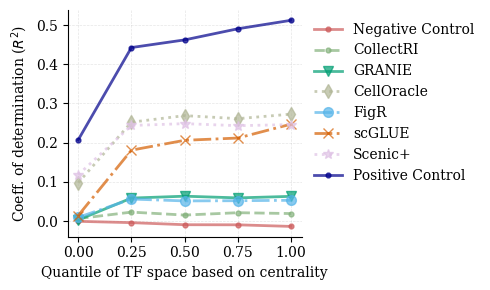

In [173]:
thetas_experiment = pd.read_csv(f'{results_folder}/benchmark/theta_experiment/reg1.csv', index_col=0)

def line_plot_theta(ax, results_df):
    markersize = 7
    linewidth = 2

    ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')
    xs = np.linspace(0, 1, 5)
    for method, series in results_df.iterrows():        
        ax.plot(
            xs, series, label=method, color=COLORS[method], markersize=markersize,
            linestyle=LINESTYLES[method], marker=MARKERS[method], alpha=0.7, linewidth=linewidth
        )

    ax.set_xticks(xs)
    # ax.set_title(f'{surragate_names[norm_method]} ({reg_type})')
    ax.set_ylabel(r'Coeff. of determination ($R^2$)')
    
        
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel(r'Quantile of TF space based on centrality')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

line_plot_theta(ax, thetas_experiment)
plt.tight_layout()
plt.savefig(f'{results_folder}/benchmark/figs/first-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()

## Reg 2

In [183]:
!ls ../../

dockers  grn_benchmark	task_grn_benchmark


In [185]:
with open(os.path.join(resources_folder, 'prior', 'consensus-num-regulators.json'), 'r') as f:
    data = json.load(f)
gene_names_ = np.asarray(list(data.keys()), dtype=object)
n_features = {}
for theta in ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']:
    n_features[theta] = np.asarray([data[gene_name][theta] for gene_name in gene_names_], dtype=int)
n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

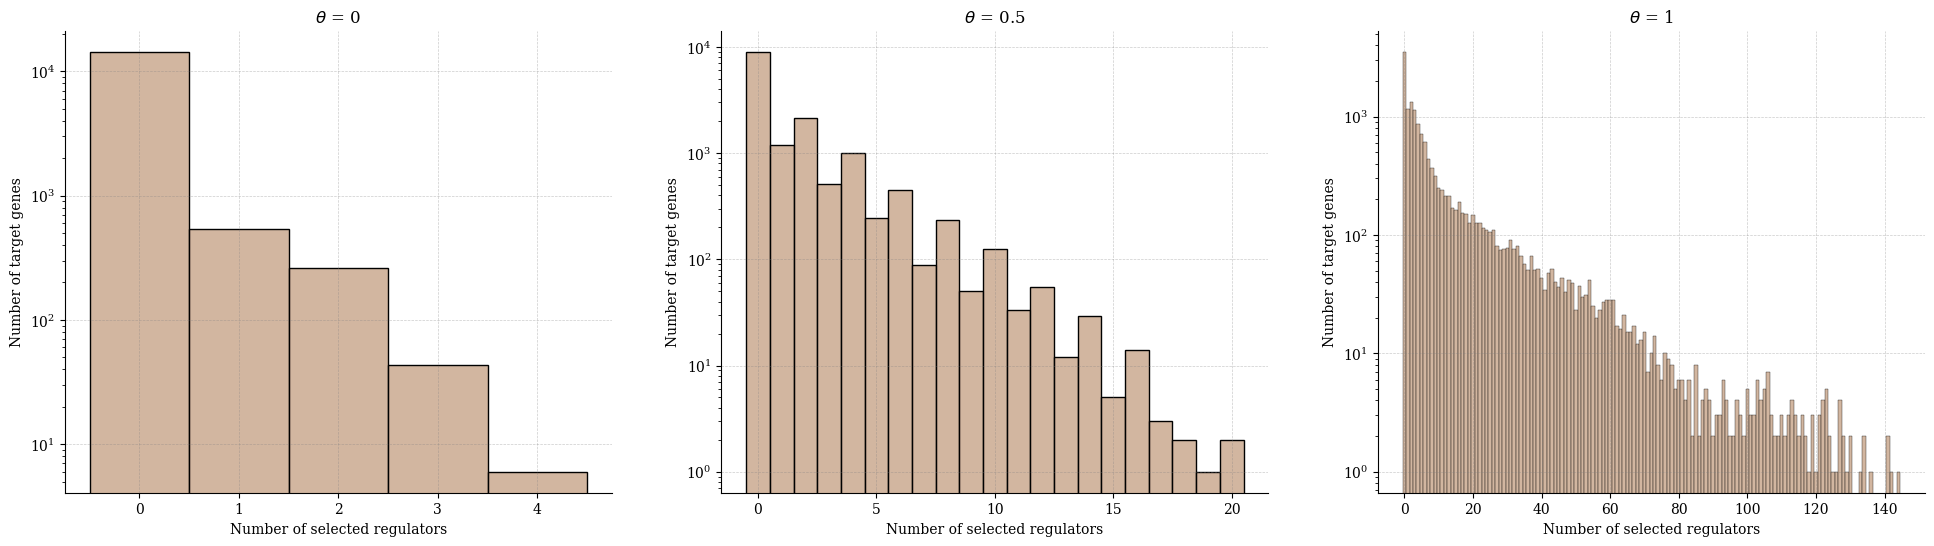

In [187]:
plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
seaborn.histplot(data=n_features['0'], ax=ax, discrete=True, color='#C49E81')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0')

ax = plt.subplot(1, 3, 2)
seaborn.histplot(data=n_features['0.5'], ax=ax, discrete=True, color='#C49E81')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0.5')

ax = plt.subplot(1, 3, 3)
seaborn.histplot(n_features['1'], ax=ax, discrete=True, color='#C49E81')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 1')

plt.savefig(f'{results_folder}/benchmark/figs/theta_reg2.png', dpi=300, transparent=True)
plt.show()

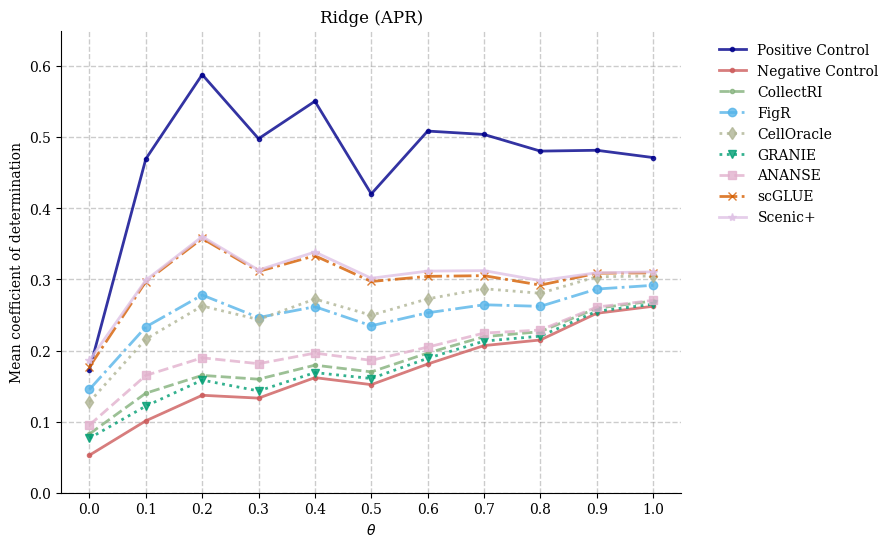

In [190]:
SORTED_METHODS = ['positive-control', 'negative-control', 'collectRI', 'FigR', 'CellOracle', 'GRANIE', 'ANANSE', 'scGLUE', 'scenicplus']
surragate_names['positive-control'] = 'Positive Control'
surragate_names['negative-control'] = 'Negative Control'
for name in ['FigR', 'GRANIE', 'ANANSE', 'scGLUE']:
    surragate_names[name] = name

plt.figure(figsize=(8, 6))

norm2_t = 'apr'
estimator_t = 'ridge'
ax = plt.subplot(1, 1, 1)
ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
xs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for method in SORTED_METHODS:

    series = []

    for theta in xs:
        with open(os.path.join(results_folder, 'benchmark/theta_experiment/reg2', str(theta), f'{method}.results.json'), 'r') as f:
            results = json.load(f)
        
        r2 = []
        for i in range(len(results['scores'])):
            gene_name = results['gene_names'][i]
            if n_features[str(theta)][n_features_dict[gene_name]] != 0:
                r2.append(results['scores'][i]['r2'])

        series.append(float(np.mean(r2)))
    
    ax.plot(
        xs, series, label=surragate_names[method], color=COLORS[surragate_names[method]],
        linestyle=LINESTYLES[surragate_names[method]], marker=MARKERS[surragate_names[method]], alpha=.8, linewidth=2,
    )

ax.set_xticks(xs)

ax.set_title('Ridge (APR)')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Mean coefficient of determination')
ax.set_ylim([0, 0.65])
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', frameon=False)
plt.savefig(f'{results_folder}/benchmark/figs/second-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()

# Reg 2, all datasets, 200 samples

In [141]:

# estimator_t = 'ridge'

# cols = ['min', 'median', 'max']

# df_grn_dict = {}
# for method in grn_models+['positive-control','negative-control']:
#     df_grn = pd.DataFrame(columns=cols)
#     for layer in datasets:
#         row = []
#         for reduction_t in cols:
#             filepath = os.path.join(RESULTS_DIR, layer, estimator_t, reduction_t, f'{method}.results.json')
#             try:
#                 with open(filepath, 'r') as f:
#                     results = json.load(f)
#             except FileNotFoundError:
#                 print(f'Cannot open "{filepath}"')
#             r2 = []
#             for i in range(len(results['scores'])):
#                 r2.append(results['scores'][i]['r2'])
#             r2 = np.asarray(r2)
#             row.append(np.mean(r2))
        
#         df_grn.loc[layer] = row
#     df_grn.columns = ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']
#     method = method.replace('-','_')
#     df_grn_dict[method] = df_grn


# # plt.savefig('../output/benchmark/figs/second-validation-heatmap.png', dpi=300, transparent=True)

In [142]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# ax =axes[0]
# col = 'static-theta-0.0'
# scores = extract_col(df_grn_dict, col)
# headmap(scores, name=surragate_names[col], ax=ax)

# ax =axes[1]
# col = 'static-theta-0.5'
# scores_reg2_1 = extract_col(df_grn_dict, col)
# headmap(scores_reg2_1, name=surragate_names[col], ax=ax)

# ax =axes[2]
# col = 'static-theta-1.0'
# scores = extract_col(df_grn_dict, col)
# headmap(scores, name=surragate_names[col], ax=ax)

# plt.show()
# fig.savefig(f"{results_folder}/figs/benchmark_all_layers_reg2.png", dpi=300, transparent=True, bbox_inches='tight')


# All layers

In [143]:
# base_folder = '../../task_grn_benchmark/resources/results/subsample_200_gb/'

# result_file = f'{base_folder}/scores.yaml'
# with open(result_file, 'r') as file:
#     data = yaml.safe_load(file)
# dfs = {}
# for entry in data:
#     method_id = entry['method_id']
#     dataset_id = entry['dataset_id']
#     if method_id not in dfs:
#         dfs[method_id] = pd.DataFrame()
#     metrics_dict = dict(zip(entry['metric_ids'], entry['metric_values']))
#     df_entry = pd.DataFrame(metrics_dict, index=[dataset_id])
#     dfs[method_id] = pd.concat([dfs[method_id], df_entry])
# df_grn_dict = {}
# for name in grn_models:
#     # df_grn = pd.concat([dfs.get(f'reg1-{name}'), dfs.get(f'reg2-{name}')], axis=1)
#     df_grn = pd.concat([dfs.get(f'reg1-{name}')], axis=1)
#     print(name)
#     df_grn_dict[name] = df_grn
# to_save_dir = '../results_folder/benchmark/200'
# for name, df in df_grn_dict.items():
#     df_reg2 = pd.read_csv(f'{to_save_dir}/{name}.csv', index_col=0)
#     df = pd.concat([df, df_reg2], axis=1)
#     df.to_csv(f'{to_save_dir}/{name}.csv')

In [144]:
to_read_dir = '../results_folder/benchmark/200'
df_grn_dict = {}
for name in controls + grn_models:
    df = pd.read_csv(f'{to_read_dir}/{name}.csv', index_col=0)
    df_grn_dict[name] = df

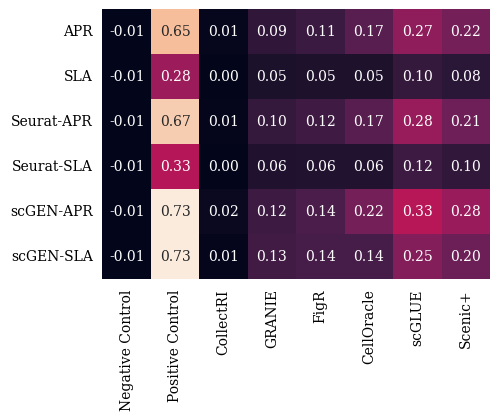

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey=False)

col = 'ex(False)_tf(-1)'
scores_1_1 = extract_col(df_grn_dict, col)
headmap(scores_1_1, name='', ax=ax)

fig.savefig(f"{results_folder}/benchmark/figs/benchmark_all_layers_reg1.png", dpi=300, transparent=True, bbox_inches='tight')


In [147]:
# Reg 1
df_all = pd.concat([extract_col(df_grn_dict, col) for col in ['ex(True)_tf(-1)', 'ex(True)_tf(140)', 'ex(False)_tf(-1)', 'ex(False)_tf(140)']], axis=1)


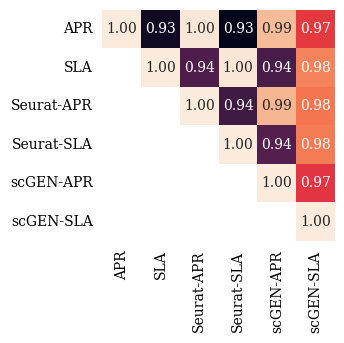

In [148]:

from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)

df_corr = df_all.T.corr().round(3)

# Combine both correlation matrices to find global min and max
vmin = np.nanmin(df_corr)
vmax = np.nanmax(df_corr)

mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

df_corr.where(~mask, other=np.nan, inplace=True)

sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
# ax.set_title('Regression 1', pad=10)
plt.savefig(f'{results_folder}/benchmark/figs/datasets-correlation-reg1.png', dpi=300, transparent=True,  bbox_inches='tight')


In [149]:
pearsonr(df_all.iloc[0,:], df_all.iloc[4,:])

PearsonRResult(statistic=0.9911647235650765, pvalue=6.970796422897098e-28)

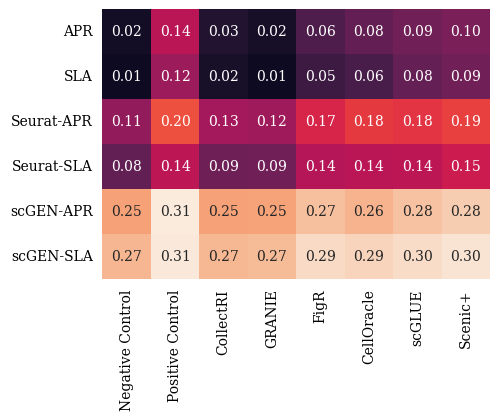

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey=False)

col = 'static-theta-0.5'
scores_1_1 = extract_col(df_grn_dict, col)
headmap(scores_1_1, name='', ax=ax)


fig.savefig(f"{results_folder}/benchmark/figs/benchmark_all_layers_reg2.png", dpi=300, transparent=True, bbox_inches='tight')

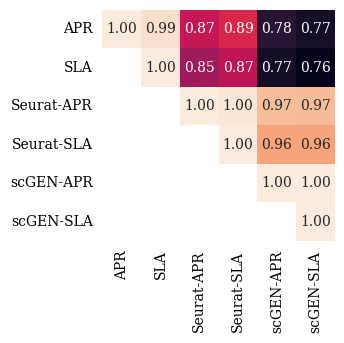

In [175]:
# Reg 2
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)
df_all = pd.concat([extract_col(df_grn_dict, col) for col in ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']], axis=1)

df_corr = df_all.T.corr().round(3)

# Combine both correlation matrices to find global min and max
vmin = np.nanmin(df_corr)
vmax = np.nanmax(df_corr)

mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

df_corr.where(~mask, other=np.nan, inplace=True)

sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
# ax.set_title('Regression 1', pad=10)
plt.savefig(f'{results_folder}/benchmark/figs/datasets-correlation-reg2.png', dpi=300, transparent=True,  bbox_inches='tight')


In [151]:
# Reg 2

layers = ['scGEN-APR', 'scGEN-SLA']

scores_reg2_0 = extract_col(df_grn_dict, col = 'static-theta-0.0')
scores_reg2_1 = extract_col(df_grn_dict, col = 'static-theta-0.5')
scores_reg2_2 = extract_col(df_grn_dict, col = 'static-theta-1.0')

df_concat = pd.concat([scores_reg2_0.loc[layers], scores_reg2_1.loc[layers], scores_reg2_2.loc[layers]], axis=1)
df_concat.T.corr().round(3)


,scGEN-APR,scGEN-SLA
scGEN-APR,1.0,1.0
scGEN-SLA,1.0,1.0


In [152]:
pearsonr(df_concat.iloc[0,:], df_concat.iloc[1,:])

PearsonRResult(statistic=0.9995143767807402, pvalue=1.2174533867600488e-34)

# Full datasets

## Reg1 


In [168]:
dfs = {}
for method_id in grn_models+controls:
    df = pd.read_csv(f'{results_folder}/benchmark/final/reg1-{method_id}.csv', index_col=0)
    dfs[method_id] = df

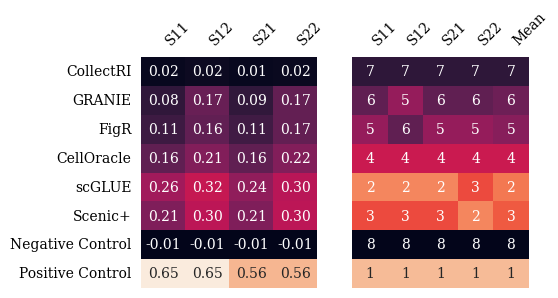

In [170]:
for i, name in enumerate(grn_models+controls):
    df_grn = dfs[name]
    df_grn.index = [name]
    if i == 0:
        scores_mat = df_grn
    else:
        scores_mat = pd.concat([scores_mat, df_grn], axis=0) 
scores_mat.drop(columns=['Mean'], inplace=True)

fig, axes = plt.subplots(1, 2 , figsize=(5,3), sharey=True)
scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat = scores_mat[['S11', 'S12', 'S21', 'S22']]
ax = axes[0]
headmap(scores_mat, name='', ax=ax)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

ax = axes[1]
scores_rank = scores_mat.rank(ascending=False)
scores_rank['Mean'] = scores_rank.mean(axis=1)
headmap_rank(scores_rank, name='', ax=ax)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
plt.savefig(f'{results_folder}/benchmark/figs/final-reg1.png', dpi=300, transparent=True,  bbox_inches='tight')

## reg 2

In [155]:
dataset_id = 'scgen_pearson'
dfs = {}
for method_id in grn_models+controls:
    df = pd.read_csv(f'{results_folder}/benchmark/final/reg2-{dataset_id}-{method_id}.csv', index_col=0)
    dfs[method_id] = df

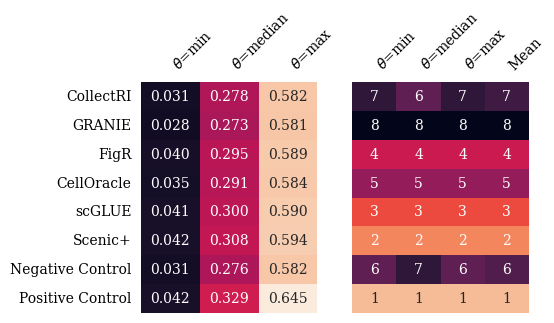

In [156]:
for i, name in enumerate(grn_models+controls):
    df_grn = dfs[name]
    df_grn.index = [name]
    if i == 0:
        scores_mat = df_grn
    else:
        scores_mat = pd.concat([scores_mat, df_grn], axis=0) 
scores_mat.drop(columns=['Mean'], inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(5,3), sharey=True)
scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)

ax = axes[0]
headmap(scores_mat, name='', ax=ax, fmt='.03f')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

ax = axes[1]
scores_rank = scores_mat.rank(ascending=False)
scores_rank['Mean'] = scores_rank.mean(axis=1)
headmap_rank(scores_rank, name='', ax=ax)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

plt.savefig(f'{results_folder}/benchmark/figs/final-reg2.png', dpi=300, transparent=True,  bbox_inches='tight')

# Infer

In [157]:
# pd.read_csv('../resources/results/trace.txt', sep='\t')

# Sythetic data

In [158]:
pd.read_csv('../input/grn_2k/grn_2k.csv').target.nunique()

1988

In [159]:
pd.read_csv('../input/grn_2k/grn_2k.csv').to_csv('../input/grn_2k/grn_2k.csv')

In [160]:
net = pd.read_csv('../input/grn_2k/grn_2k.csv').pivot(index='source',columns='target', values='weight').fillna(0)
(net==0).sum().sum()/(net.shape[0]*net.shape[1])

0.9981694679354322

In [161]:
gene_names = net.columns

In [162]:
# pd.read_csv('../input/grn_2k/grn_2k_unperturbed.csv')

In [163]:
import anndata as ad 
adata = ad.read_h5ad('../input/grn_2k/grn_2k_500_kos.h5ad')[:, :1988] 
adata.layers['values'] = adata.X
adata.var = pd.DataFrame(index=gene_names)
adata.write('../input/grn_2k/prturb.h5ad')


/tmp/ipykernel_261452/3298345632.py:3: ImplicitModificationWarning: Setting element `.layers['values']` of view, initializing view as actual.
  adata.layers['values'] = adata.X
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
